# Method 6 - Best Ideas DGTW Select

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - dgtw_cont).dropna()
monthly_return.name = 'port_return'

## Plot Performance

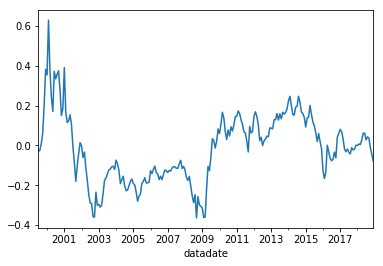

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.381847
2000-12-31   -0.141760
2001-12-31   -0.144980
2002-12-31   -0.310556
2003-12-31    0.257907
2004-12-31   -0.054262
2005-12-31   -0.020481
2006-12-31    0.070282
2007-12-31    0.026436
2008-12-31   -0.224847
2009-12-31    0.560504
2010-12-31    0.058002
2011-12-31   -0.065472
2012-12-31    0.016452
2013-12-31    0.087930
2014-12-31   -0.036049
2015-12-31   -0.136878
2016-12-31    0.077328
2017-12-31   -0.056132
2018-12-31   -0.079796
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     73.26
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.92e-40
Time:                        14:29:55   Log-Likelihood:                 435.90
No. Observations:                 234   AIC:                            -861.8
Df Residuals:                     229   BIC:                            -844.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.003      0.779      0.437      -0.003       0.007
mktrf          0.3177      0.071      4.486      0.000       0.178       0.457
me             0.3617      0.082      4.391      0.000       0.199       0.524
ia            -0.2566      0.125     -2.049      0.042      -0.503      -0.010
roe           -0.8164      0.107     -7.618      0.000      -1.028      -0.605
==============================================================================
Omnibus:                      157.463   Durbin-Watson:                   2.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2977.898
Skew:                           2.272   Prob(JB):                         0.00
Kurtosis:                      19.875   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     47.56
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.52e-29
Time:                        14:29:55   Log-Likelihood:                 435.90
No. Observations:                 234   AIC:                            -861.8
Df Residuals:                     229   BIC:                            -844.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      0.853      0.394      -0.003       0.007
mktrf          0.3177      0.130      2.441      0.015       0.063       0.573
me             0.3617      0.136      2.665      0.008       0.096       0.628
ia            -0.2566      0.174     -1.473      0.141      -0.598       0.085
roe           -0.8164      0.135     -6.037      0.000      -1.081      -0.551
==============================================================================
Omnibus:                      157.463   Durbin-Watson:                   2.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2977.898
Skew:                           2.272   Prob(JB):                         0.00
Kurtosis:                      19.875   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     63.34
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.53e-36
Time:                        14:29:55   Log-Likelihood:                 435.90
No. Observations:                 234   AIC:                            -861.8
Df Residuals:                     229   BIC:                            -844.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      0.814      0.416      -0.003       0.007
mktrf          0.3177      0.122      2.598      0.009       0.078       0.557
me             0.3617      0.148      2.451      0.014       0.072       0.651
ia            -0.2566      0.172     -1.495      0.135      -0.593       0.080
roe           -0.8164      0.134     -6.086      0.000      -1.079      -0.553
==============================================================================
Omnibus:                      157.463   Durbin-Watson:                   2.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2977.898
Skew:                           2.272   Prob(JB):                         0.00
Kurtosis:                      19.875   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     58.66
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.54e-39
Time:                        14:29:55   Log-Likelihood:                 436.25
No. Observations:                 234   AIC:                            -860.5
Df Residuals:                     228   BIC:                            -839.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.003      0.674      0.501      -0.003       0.007
mktrf          0.3959      0.071      5.576      0.000       0.256       0.536
smb            0.3279      0.094      3.499      0.001       0.143       0.512
hml           -0.0624      0.110     -0.565      0.572      -0.280       0.155
rmw           -0.8292      0.125     -6.638      0.000      -1.075      -0.583
cma            0.0464      0.159      0.292      0.770      -0.266       0.359
==============================================================================
Omnibus:                      155.625   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2117.257
Skew:                           2.370   Prob(JB):                         0.00
Kurtosis:                      16.953   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     78.76
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.00e-47
Time:                        14:29:55   Log-Likelihood:                 436.25
No. Observations:                 234   AIC:                            -860.5
Df Residuals:                     228   BIC:                            -839.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      0.790      0.429      -0.003       0.006
mktrf          0.3959      0.085      4.651      0.000       0.229       0.563
smb            0.3279      0.104      3.166      0.002       0.125       0.531
hml           -0.0624      0.182     -0.343      0.731      -0.419       0.294
rmw           -0.8292      0.129     -6.440      0.000      -1.081      -0.577
cma            0.0464      0.182      0.255      0.799      -0.310       0.403
==============================================================================
Omnibus:                      155.625   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2117.257
Skew:                           2.370   Prob(JB):                         0.00
Kurtosis:                      16.953   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     114.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.82e-60
Time:                        14:29:55   Log-Likelihood:                 436.25
No. Observations:                 234   AIC:                            -860.5
Df Residuals:                     228   BIC:                            -839.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      0.752      0.452      -0.003       0.006
mktrf          0.3959      0.069      5.712      0.000       0.260       0.532
smb            0.3279      0.112      2.921      0.003       0.108       0.548
hml           -0.0624      0.157     -0.398      0.691      -0.370       0.245
rmw           -0.8292      0.128     -6.502      0.000      -1.079      -0.579
cma            0.0464      0.157      0.295      0.768      -0.262       0.355
==============================================================================
Omnibus:                      155.625   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2117.257
Skew:                           2.370   Prob(JB):                         0.00
Kurtosis:                      16.953   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     62.79
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.23e-36
Time:                        14:29:55   Log-Likelihood:                 426.13
No. Observations:                 234   AIC:                            -842.3
Df Residuals:                     229   BIC:                            -825.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.003     -0.451      0.652      -0.006       0.004
mktrf          0.4912      0.068      7.225      0.000       0.357       0.625
smb            0.7009      0.085      8.260      0.000       0.534       0.868
hml           -0.2545      0.084     -3.019      0.003      -0.421      -0.088
umd           -0.2296      0.055     -4.151      0.000      -0.339      -0.121
==============================================================================
Omnibus:                      137.761   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1721.518
Skew:                           2.025   Prob(JB):                         0.00
Kurtosis:                      15.656   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     33.66
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.38e-22
Time:                        14:29:55   Log-Likelihood:                 426.13
No. Observations:                 234   AIC:                            -842.3
Df Residuals:                     229   BIC:                            -825.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.002     -0.522      0.602      -0.006       0.003
mktrf          0.4912      0.107      4.579      0.000       0.281       0.701
smb            0.7009      0.124      5.674      0.000       0.459       0.943
hml           -0.2545      0.129     -1.976      0.048      -0.507      -0.002
umd           -0.2296      0.086     -2.655      0.008      -0.399      -0.060
==============================================================================
Omnibus:                      137.761   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1721.518
Skew:                           2.025   Prob(JB):                         0.00
Kurtosis:                      15.656   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     39.17
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.71e-25
Time:                        14:29:55   Log-Likelihood:                 426.13
No. Observations:                 234   AIC:                            -842.3
Df Residuals:                     229   BIC:                            -825.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.002     -0.511      0.609      -0.006       0.003
mktrf          0.4912      0.097      5.047      0.000       0.300       0.682
smb            0.7009      0.124      5.651      0.000       0.458       0.944
hml           -0.2545      0.122     -2.094      0.036      -0.493      -0.016
umd           -0.2296      0.083     -2.759      0.006      -0.393      -0.066
==============================================================================
Omnibus:                      137.761   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1721.518
Skew:                           2.025   Prob(JB):                         0.00
Kurtosis:                      15.656   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     38.44
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.14e-20
Time:                        14:29:55   Log-Likelihood:                 202.15
No. Observations:                 120   AIC:                            -394.3
Df Residuals:                     115   BIC:                            -380.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.004      1.092      0.277      -0.004       0.013
mktrf          0.2158      0.118      1.826      0.070      -0.018       0.450
me             0.3751      0.117      3.213      0.002       0.144       0.606
ia            -0.4506      0.183     -2.465      0.015      -0.813      -0.089
roe           -0.8235      0.162     -5.090      0.000      -1.144      -0.503
==============================================================================
Omnibus:                       78.674   Durbin-Watson:                   2.243
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              764.509
Skew:                           1.989   Prob(JB):                    9.75e-167
Kurtosis:                      14.708   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     55.49
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.56e-26
Time:                        14:29:55   Log-Likelihood:                 202.15
No. Observations:                 120   AIC:                            -394.3
Df Residuals:                     115   BIC:                            -380.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.004      1.328      0.184      -0.002       0.012
mktrf          0.2158      0.203      1.063      0.288      -0.182       0.614
me             0.3751      0.169      2.218      0.027       0.044       0.707
ia            -0.4506      0.241     -1.869      0.062      -0.923       0.022
roe           -0.8235      0.199     -4.143      0.000      -1.213      -0.434
==============================================================================
Omnibus:                       78.674   Durbin-Watson:                   2.243
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              764.509
Skew:                           1.989   Prob(JB):                    9.75e-167
Kurtosis:                      14.708   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     75.50
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.90e-31
Time:                        14:29:55   Log-Likelihood:                 202.15
No. Observations:                 120   AIC:                            -394.3
Df Residuals:                     115   BIC:                            -380.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.004      1.319      0.187      -0.002       0.012
mktrf          0.2158      0.194      1.112      0.266      -0.165       0.596
me             0.3751      0.182      2.060      0.039       0.018       0.732
ia            -0.4506      0.222     -2.034      0.042      -0.885      -0.016
roe           -0.8235      0.212     -3.882      0.000      -1.239      -0.408
==============================================================================
Omnibus:                       78.674   Durbin-Watson:                   2.243
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              764.509
Skew:                           1.989   Prob(JB):                    9.75e-167
Kurtosis:                      14.708   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     32.76
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.37e-20
Time:                        14:29:55   Log-Likelihood:                 204.66
No. Observations:                 120   AIC:                            -397.3
Df Residuals:                     114   BIC:                            -380.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.004      1.145      0.255      -0.004       0.014
mktrf          0.4078      0.123      3.327      0.001       0.165       0.651
smb            0.3833      0.139      2.761      0.007       0.108       0.658
hml           -0.3051      0.170     -1.793      0.076      -0.642       0.032
rmw           -0.6343      0.201     -3.161      0.002      -1.032      -0.237
cma            0.0575      0.220      0.261      0.794      -0.378       0.493
==============================================================================
Omnibus:                       86.886   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              720.599
Skew:                           2.374   Prob(JB):                    3.34e-157
Kurtosis:                      14.027   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     102.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.38e-40
Time:                        14:29:55   Log-Likelihood:                 204.66
No. Observations:                 120   AIC:                            -397.3
Df Residuals:                     114   BIC:                            -380.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.003      1.725      0.084      -0.001       0.011
mktrf          0.4078      0.153      2.665      0.008       0.108       0.708
smb            0.3833      0.150      2.556      0.011       0.089       0.677
hml           -0.3051      0.172     -1.778      0.075      -0.641       0.031
rmw           -0.6343      0.197     -3.227      0.001      -1.019      -0.249
cma            0.0575      0.192      0.300      0.764      -0.318       0.433
==============================================================================
Omnibus:                       86.886   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              720.599
Skew:                           2.374   Prob(JB):                    3.34e-157
Kurtosis:                      14.027   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     142.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.68e-47
Time:                        14:29:55   Log-Likelihood:                 204.66
No. Observations:                 120   AIC:                            -397.3
Df Residuals:                     114   BIC:                            -380.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.003      1.725      0.084      -0.001       0.011
mktrf          0.4078      0.119      3.422      0.001       0.174       0.641
smb            0.3833      0.150      2.562      0.010       0.090       0.677
hml           -0.3051      0.143     -2.141      0.032      -0.584      -0.026
rmw           -0.6343      0.202     -3.138      0.002      -1.030      -0.238
cma            0.0575      0.153      0.376      0.707      -0.242       0.357
==============================================================================
Omnibus:                       86.886   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              720.599
Skew:                           2.374   Prob(JB):                    3.34e-157
Kurtosis:                      14.027   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     40.46
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.00e-21
Time:                        14:29:55   Log-Likelihood:                 203.92
No. Observations:                 120   AIC:                            -397.8
Df Residuals:                     115   BIC:                            -383.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.004      0.500      0.618      -0.006       0.011
mktrf          0.4749      0.103      4.628      0.000       0.272       0.678
smb            0.7021      0.117      6.010      0.000       0.471       0.933
hml           -0.4498      0.117     -3.844      0.000      -0.682      -0.218
umd           -0.2097      0.072     -2.907      0.004      -0.353      -0.067
==============================================================================
Omnibus:                       81.663   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              744.941
Skew:                           2.128   Prob(JB):                    1.73e-162
Kurtosis:                      14.440   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     40.34
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.41e-21
Time:                        14:29:55   Log-Likelihood:                 203.92
No. Observations:                 120   AIC:                            -397.8
Df Residuals:                     115   BIC:                            -383.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.003      0.673      0.501      -0.004       0.008
mktrf          0.4749      0.159      2.995      0.003       0.164       0.786
smb            0.7021      0.127      5.515      0.000       0.453       0.952
hml           -0.4498      0.157     -2.870      0.004      -0.757      -0.143
umd           -0.2097      0.095     -2.197      0.028      -0.397      -0.023
==============================================================================
Omnibus:                       81.663   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              744.941
Skew:                           2.128   Prob(JB):                    1.73e-162
Kurtosis:                      14.440   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     53.17
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.72e-25
Time:                        14:29:55   Log-Likelihood:                 203.92
No. Observations:                 120   AIC:                            -397.8
Df Residuals:                     115   BIC:                            -383.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.003      0.664      0.507      -0.004       0.008
mktrf          0.4749      0.146      3.252      0.001       0.189       0.761
smb            0.7021      0.115      6.114      0.000       0.477       0.927
hml           -0.4498      0.134     -3.364      0.001      -0.712      -0.188
umd           -0.2097      0.097     -2.170      0.030      -0.399      -0.020
==============================================================================
Omnibus:                       81.663   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              744.941
Skew:                           2.128   Prob(JB):                    1.73e-162
Kurtosis:                      14.440   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     39.96
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.44e-20
Time:                        14:29:55   Log-Likelihood:                 255.09
No. Observations:                 114   AIC:                            -500.2
Df Residuals:                     109   BIC:                            -486.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.003     -0.780      0.437      -0.007       0.003
mktrf          0.4856      0.078      6.256      0.000       0.332       0.640
me             0.1748      0.120      1.458      0.148      -0.063       0.412
ia             0.1005      0.166      0.604      0.547      -0.229       0.430
roe           -0.8948      0.146     -6.125      0.000      -1.184      -0.605
==============================================================================
Omnibus:                       11.492   Durbin-Watson:                   2.116
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               15.977
Skew:                           0.512   Prob(JB):                     0.000339
Kurtosis:                       4.522   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     35.28
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.97e-19
Time:                        14:29:55   Log-Likelihood:                 255.09
No. Observations:                 114   AIC:                            -500.2
Df Residuals:                     109   BIC:                            -486.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.002     -1.257      0.209      -0.005       0.001
mktrf          0.4856      0.099      4.910      0.000       0.292       0.680
me             0.1748      0.161      1.084      0.278      -0.141       0.491
ia             0.1005      0.187      0.537      0.591      -0.266       0.467
roe           -0.8948      0.237     -3.781      0.000      -1.359      -0.431
==============================================================================
Omnibus:                       11.492   Durbin-Watson:                   2.116
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               15.977
Skew:                           0.512   Prob(JB):                     0.000339
Kurtosis:                       4.522   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     39.18
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.69e-20
Time:                        14:29:55   Log-Likelihood:                 255.09
No. Observations:                 114   AIC:                            -500.2
Df Residuals:                     109   BIC:                            -486.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.001     -1.403      0.161      -0.005       0.001
mktrf          0.4856      0.088      5.500      0.000       0.313       0.659
me             0.1748      0.186      0.938      0.348      -0.190       0.540
ia             0.1005      0.207      0.484      0.628      -0.306       0.507
roe           -0.8948      0.236     -3.785      0.000      -1.358      -0.431
==============================================================================
Omnibus:                       11.492   Durbin-Watson:                   2.116
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               15.977
Skew:                           0.512   Prob(JB):                     0.000339
Kurtosis:                       4.522   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     31.74
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.15e-20
Time:                        14:29:55   Log-Likelihood:                 255.16
No. Observations:                 114   AIC:                            -498.3
Df Residuals:                     108   BIC:                            -481.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0028      0.003     -1.052      0.295      -0.008       0.002
mktrf          0.4920      0.074      6.619      0.000       0.345       0.639
smb            0.1264      0.121      1.048      0.297      -0.113       0.366
hml            0.3786      0.154      2.460      0.015       0.074       0.684
rmw           -0.9333      0.188     -4.952      0.000      -1.307      -0.560
cma           -0.1177      0.239     -0.492      0.624      -0.592       0.356
==============================================================================
Omnibus:                       20.057   Durbin-Watson:                   2.125
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.562
Skew:                           0.623   Prob(JB):                     2.85e-11
Kurtosis:                       5.945   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     33.91
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.10e-20
Time:                        14:29:55   Log-Likelihood:                 255.16
No. Observations:                 114   AIC:                            -498.3
Df Residuals:                     108   BIC:                            -481.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0028      0.002     -1.178      0.239      -0.007       0.002
mktrf          0.4920      0.067      7.295      0.000       0.360       0.624
smb            0.1264      0.133      0.949      0.342      -0.135       0.387
hml            0.3786      0.103      3.679      0.000       0.177       0.580
rmw           -0.9333      0.217     -4.291      0.000      -1.360      -0.507
cma           -0.1177      0.181     -0.650      0.515      -0.472       0.237
==============================================================================
Omnibus:                       20.057   Durbin-Watson:                   2.125
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.562
Skew:                           0.623   Prob(JB):                     2.85e-11
Kurtosis:                       5.945   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     49.49
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.09e-26
Time:                        14:29:55   Log-Likelihood:                 255.16
No. Observations:                 114   AIC:                            -498.3
Df Residuals:                     108   BIC:                            -481.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0028      0.002     -1.318      0.187      -0.007       0.001
mktrf          0.4920      0.064      7.639      0.000       0.366       0.618
smb            0.1264      0.148      0.853      0.393      -0.164       0.417
hml            0.3786      0.091      4.156      0.000       0.200       0.557
rmw           -0.9333      0.182     -5.120      0.000      -1.291      -0.576
cma           -0.1177      0.200     -0.589      0.556      -0.510       0.274
==============================================================================
Omnibus:                       20.057   Durbin-Watson:                   2.125
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.562
Skew:                           0.623   Prob(JB):                     2.85e-11
Kurtosis:                       5.945   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     30.09
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.29e-17
Time:                        14:29:55   Log-Likelihood:                 246.05
No. Observations:                 114   AIC:                            -482.1
Df Residuals:                     109   BIC:                            -468.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.003     -1.367      0.174      -0.010       0.002
mktrf          0.5317      0.080      6.675      0.000       0.374       0.690
smb            0.3372      0.124      2.715      0.008       0.091       0.583
hml            0.3221      0.128      2.519      0.013       0.069       0.576
umd           -0.2490      0.096     -2.581      0.011      -0.440      -0.058
==============================================================================
Omnibus:                       21.468   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.225
Skew:                           0.628   Prob(JB):                     2.27e-13
Kurtosis:                       6.268   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     43.04
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.28e-21
Time:                        14:29:55   Log-Likelihood:                 246.05
No. Observations:                 114   AIC:                            -482.1
Df Residuals:                     109   BIC:                            -468.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.002     -1.810      0.070      -0.008       0.000
mktrf          0.5317      0.075      7.095      0.000       0.385       0.679
smb            0.3372      0.139      2.418      0.016       0.064       0.611
hml            0.3221      0.140      2.299      0.022       0.047       0.597
umd           -0.2490      0.094     -2.656      0.008      -0.433      -0.065
==============================================================================
Omnibus:                       21.468   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.225
Skew:                           0.628   Prob(JB):                     2.27e-13
Kurtosis:                       6.268   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     61.34
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.82e-27
Time:                        14:29:55   Log-Likelihood:                 246.05
No. Observations:                 114   AIC:                            -482.1
Df Residuals:                     109   BIC:                            -468.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.002     -2.058      0.040      -0.008      -0.000
mktrf          0.5317      0.072      7.418      0.000       0.391       0.672
smb            0.3372      0.134      2.511      0.012       0.074       0.600
hml            0.3221      0.137      2.359      0.018       0.054       0.590
umd           -0.2490      0.092     -2.717      0.007      -0.429      -0.069
==============================================================================
Omnibus:                       21.468   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.225
Skew:                           0.628   Prob(JB):                     2.27e-13
Kurtosis:                       6.268   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""